In [359]:
# !pip install vaderSentiment
# !pip install -U textblob
# !pip install swifter
!pip install gensim==3.8.3

In [360]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from tqdm import tqdm
from time import time
import pandas as pd
import numpy as np
import regex as re
import unicodedata
import swifter
import gc
import json

import nltk
sns.set_style('white')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TweetTokenizer
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [361]:
df = pd.read_csv('../data/tweets_01-08-2021.csv')
df

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
...,...,...,...,...,...,...,...,...,...
56566,1319485303363571714,RT @RandPaul: I don’t know why @JoeBiden think...,t,f,Twitter for iPhone,0,20683,2020-10-23 03:46:25,f
56567,1319484210101379072,RT @EliseStefanik: President @realDonaldTrump ...,t,f,Twitter for iPhone,0,9869,2020-10-23 03:42:05,f
56568,1319444420861829121,RT @TeamTrump: LIVE: Presidential Debate #Deba...,t,f,Twitter for iPhone,0,8197,2020-10-23 01:03:58,f
56569,1319384118849949702,Just signed an order to support the workers of...,f,f,Twitter for iPhone,176289,36001,2020-10-22 21:04:21,f


# Sentiment Analysis

## Pre-processing the data

Source: https://link-springer-com.ezproxy.cul.columbia.edu/content/pdf/10.1007%2F978-3-319-09339-0.pdf (page 617)

In [362]:
# Add additional feature 'retweeted'
tweets = df['text'].to_list()
values = []

for tweet in tweets:
    if tweet.startswith('RT'):
        value = True
    else:
        value = False

    values.append(value)
    
df['retweeted'] = values

In [363]:
# Step 1: Denoising – Remove Username, Hashtags, Links, Change to lowercase
def denoise(tweets):
    
    clean_tweets = []

    for tweet in tweets:
        result = unicodedata.normalize('NFKD', tweet)
        result = re.sub("@(\w{1,15})", " ", result) # mentions
        result = re.sub("#(\w{1,15})", " ", result) # hashtags
        result = re.sub("https?://([^\s]+)", ' ', result) # links
        result = re.sub("RT", ' ', result) # RT : 
        
        result = re.sub(" &amp", ' ', result) # &amp
        result = re.sub("[\n\r\t\0]", ' ', result) # new line, tabs, etc
        
        result = re.sub(r"\'t", "not", result)
        result = re.sub(r"\'re", " are", result)
        result = re.sub(r"\'s", " is", result)
        result = re.sub(r"\'d", " would", result)
        result = re.sub(r"\'ll", " will", result)
        result = re.sub(r"\'ve", " have", result)
        result = re.sub(r"\'m", " am", result)
        
        result = re.sub(r'\b\w\b', ' ', result) # sigle letter
        result = re.sub('[!,.-;:\+\-\()?"“”\[\]{}]', ' ', result) # punct
        
        result = re.sub('\s{2,}', ' ', result) # 2+ whitespaces

        result = result.strip()
                
        clean_tweets.append(result)
        
    return clean_tweets

In [364]:
# Step 2: Normalizing contractions
# source: https://towardsdatascience.com/text-normalization-7ecc8e084e31

def normalize_contractions(tweets):
    contraction_list = json.loads(open('../data/english_contractions.json', 'r').read())
    clean_tweets = []
    
    for tweet in tweets:
        clean_tweets.append(_normalize_contractions_text(tweet, contraction_list))
        
    return clean_tweets

def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    
    tweet = " ".join(new_token_list).strip(" ").lower()
    
    return tweet

In [365]:
def remove_stop_words(tweets):
    stopwords_english = stopwords.words('english')
    
    to_be_removed = ["haven't", "against", "not", "weren't", "won't", 'no']
    
    for word in to_be_removed:
        stopwords_english.remove(word)
        
    stopwords_english.append('pm')
    stopwords_english.append('am')

    clean_tweets = []
    
    # instantiate the tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
    
    for tweet in tweets:
        
        # tokenize the tweets
        tweet_tokens = tokenizer.tokenize(tweet)
        
        tweet_clean = ''
        
        for word in tweet_tokens: # Go through every word in your tokens list
            if word not in stopwords_english:
                tweet_clean = tweet_clean + ' ' + word
                
        clean_tweets.append(tweet_clean.strip())
        
    return clean_tweets

In [366]:
def deEmojify(tweets):
    clean_tweets = []
    
    for tweet in tweets:
        regrex_pattern = re.compile(pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
        
        clean_tweets.append(regrex_pattern.sub(r'', tweet))    
        
    return clean_tweets

In [367]:
def normalization_pipeline(tweets):

    tweets = denoise(tweets)
    tweets = deEmojify(tweets)
    tweets = normalize_contractions(tweets)
    tweets = remove_stop_words(tweets)

    return tweets

In [368]:
# load tweets
tweets = df['text'].to_list()

clean_tweets = normalization_pipeline(tweets)

In [369]:
df['sentiment_text'] = clean_tweets

In [370]:
#remove tweets that are empty
df = df[df['sentiment_text'] != '']

## Sentiment Analysis

### Part 1: Vader & TextBlob

In [371]:
def sentiment_scores(tweet):
  
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    
    sentiment_score = sid_obj.polarity_scores(tweet)['compound'] 
    blob_dict = TextBlob(tweet).sentiment
    
    sentiment_vader.append(sentiment_score)
    polarity.append(blob_dict.polarity)
    subjectivity.append(blob_dict.subjectivity)

In [372]:
# compute scores
tweets_clean = df['sentiment_text']

polarity = []
subjectivity = []
sentiment_vader = []

for tweet in tweets_clean:
    sentiment_scores(tweet)
    
df['subjectivity_score'] = subjectivity
df['TextBlob_sa'] = polarity
df['Vader_sa'] = sentiment_vader

<ipython-input-372-aad1d5f1801e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subjectivity_score'] = subjectivity
<ipython-input-372-aad1d5f1801e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TextBlob_sa'] = polarity
<ipython-input-372-aad1d5f1801e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

### Plotting the results

In [373]:
def get_rid_of_spine(axes):
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)

Text(0.5, 1.03, 'The distribution of sentiment scores')

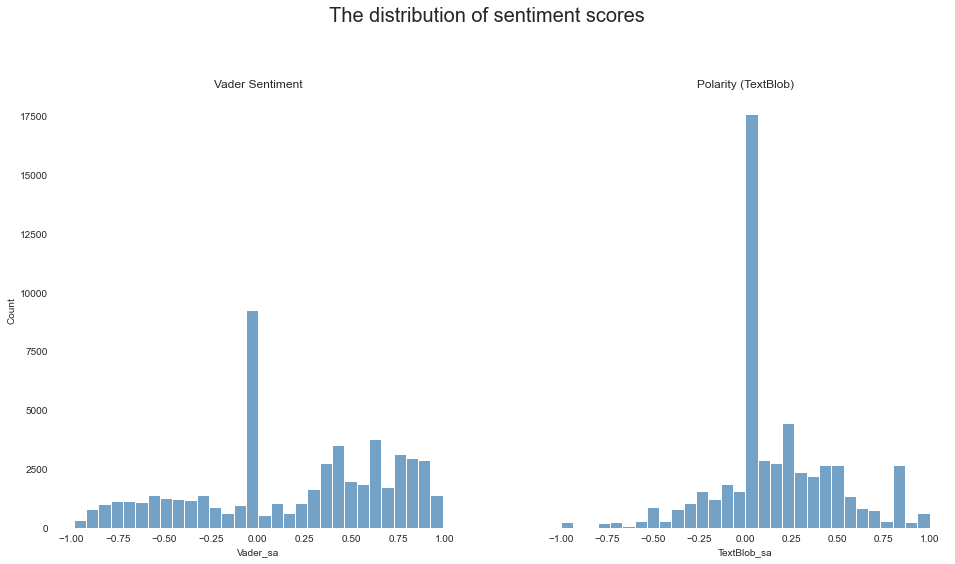

In [374]:
# Plotting polarity vs sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharey=True)
g1 = sns.histplot(x=df['Vader_sa'], color="steelblue", ax=ax1, bins = 30)
g2 = sns.histplot(x=df['TextBlob_sa'], color="steelblue", ax=ax2, bins = 30)

ax1.set_title("Vader Sentiment")
ax2.set_title("Polarity (TextBlob)")

get_rid_of_spine([ax1, ax2])
plt.suptitle("The distribution of sentiment scores", y = 1.03, fontsize=20)

Text(0.5, 1.03, 'The distribution of subjectivity score')

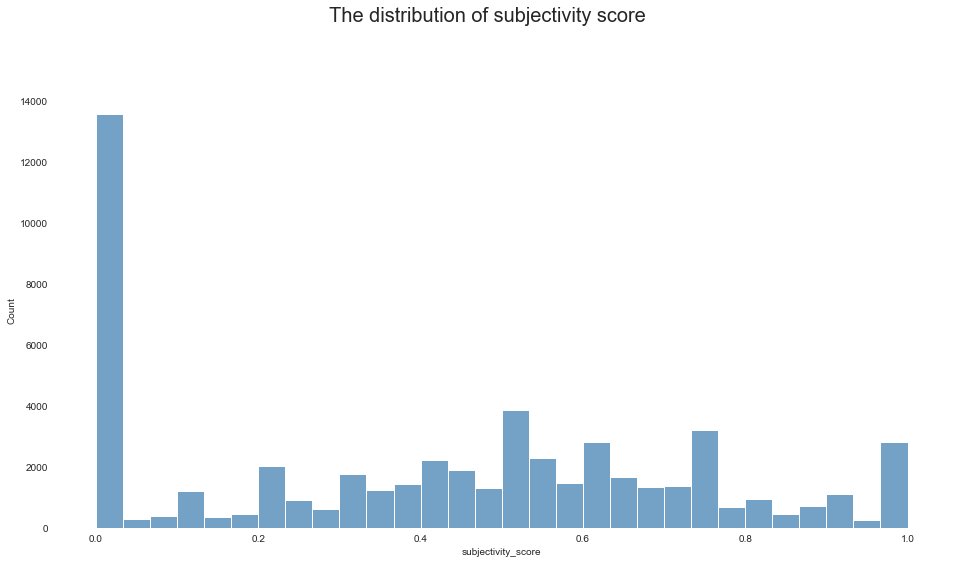

In [375]:
# Plotting objectivity
# subjectivity_score = 0: very objective
# subjectivity_score = 1: very subjective
fig, ax = plt.subplots(figsize=(16,8))
g1 = sns.histplot(x=df['subjectivity_score'], color="steelblue", bins = 30)
get_rid_of_spine([ax])
plt.suptitle("The distribution of subjectivity score", y = 1.03, fontsize=20)

In [376]:
df.to_csv(r'../output/sentiment_analysis_clean.csv', index = False)

### Part 2: Word-2-vec and KMeans

Source:  https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483 

In [377]:
# loading clean dataset
df_tweets = pd.read_csv('../output/sentiment_analysis_clean.csv')
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,retweeted,sentiment_text,subjectivity_score,TextBlob_sa,Vader_sa
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,False,republicans democrats created economic problems,0.200000,0.200000,-0.1779
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,False,thrilled back great city charlotte north carol...,0.483333,0.450000,0.9771
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,True,read letter surveillance court obtained cbs ne...,0.100000,0.100000,0.0000
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,False,unsolicited mail ballot scam major threat demo...,0.454762,0.029464,-0.9552
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,True,friendly telling events comey apparent leaking...,0.425000,0.212500,0.4939


In [378]:
# Removing empty sentiment_text
df_tweets = df_tweets[-df_tweets.sentiment_text.isna()]

# Tokenizing sentiment_text for compatibility with gensim package
df_tweets.sentiment_text = df_tweets.sentiment_text.swifter.apply(lambda x: x.split())

df_tweets.sentiment_text.head()

0    [republicans, democrats, created, economic, pr...
1    [thrilled, back, great, city, charlotte, north...
2    [read, letter, surveillance, court, obtained, ...
3    [unsolicited, mail, ballot, scam, major, threa...
4    [friendly, telling, events, comey, apparent, l...
Name: sentiment_text, dtype: object

In [379]:
corpus = [tweet for tweet in df_tweets.sentiment_text]
phrases = Phrases(corpus, min_count=10)
bigram = Phraser(phrases)
sentences = bigram[corpus]

In [380]:
# Example of sentence with bigram token
sentences[1]

['thrilled_back',
 'great',
 'city',
 'charlotte',
 'north_carolina',
 'thousands',
 'hardworking_american',
 'patriots',
 'love',
 'country',
 'cherish',
 'values',
 'respect',
 'laws',
 'always',
 'put',
 'america',
 'first',
 'thank',
 'wonderful',
 'evening']

In [ ]:
w2v_model = Word2Vec(min_count=1,
                     window=7,
                     size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     workers=-1)

start = time()

w2v_model.build_vocab(sentences, 
                      progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

In [382]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=200, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

Time to train the model: 1.61 mins


<ipython-input-382-9b3f9f8c7e0a>:7: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [383]:
w2v_model.save("../output/word2vec.model")

word_vectors = Word2Vec.load("../output/word2vec.model").wv

In [384]:
# build Kmeans model
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

[('hanna', 0.2546403706073761),
 ('reactor', 0.2425016611814499),
 ('jones', 0.229448601603508),
 ('chickens', 0.2241600900888443),
 ('eliminates', 0.21723613142967224),
 ('taj', 0.2135332226753235),
 ('donate', 0.21283449232578278),
 ('calenders', 0.20683975517749786),
 ('bought', 0.20530638098716736),
 ('ensue', 0.20398637652397156),
 ('proceedings', 0.19942763447761536),
 ('cumming', 0.19820238649845123),
 ('vaccines', 0.19622787833213806),
 ('chester', 0.19548356533050537),
 ('overflowing', 0.19547200202941895),
 ('locale', 0.19536355137825012),
 ('yt', 0.19525468349456787),
 ('begs', 0.1929004192352295),
 ('explicit', 0.19289487600326538),
 ('challenger', 0.1925903856754303),
 ('omaha', 0.19106560945510864),
 ("america'executive", 0.19088676571846008),
 ('defiance', 0.1892756223678589),
 ('dismantles', 0.18781165778636932),
 ('fig', 0.18645288050174713),
 ('create', 0.18580549955368042),
 ('se', 0.18480007350444794),
 ('diligently', 0.18452215194702148),
 ('retainer', 0.1841679513

In [413]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

words = pd.DataFrame(word_vectors.vocab.keys)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

words.head(20)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [386]:
words[['words', 'sentiment_coeff']].to_csv('../output/sentiment_dictionary.csv', index=False)

In [387]:
df_tweets.sentiment_text = df_tweets.sentiment_text.swifter.apply(lambda x: ' '.join(bigram[x]))

cut_labels = [-1, 0, 1]
cut_bins = [-1, -0.00000001, 0.00000001, 1]
df_tweets['VADER'] = pd.cut(df_tweets.Vader_sa, bins=cut_bins, labels=cut_labels)
df_tweets['TextBlob'] = pd.cut(df_tweets.TextBlob_sa, bins=cut_bins, labels=cut_labels)

df_tweets['VADER'].value_counts()

1     31055
-1    14920
0      8699
Name: VADER, dtype: int64

In [388]:
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,retweeted,sentiment_text,subjectivity_score,TextBlob_sa,Vader_sa,VADER,TextBlob
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,False,republicans democrats created economic problems,0.200000,0.200000,-0.1779,-1,1
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,False,thrilled_back great city charlotte north_carol...,0.483333,0.450000,0.9771,1,1
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,True,read letter surveillance court obtained cbs ne...,0.100000,0.100000,0.0000,0,1
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,False,unsolicited mail_ballot scam major threat demo...,0.454762,0.029464,-0.9552,-1,1
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,True,friendly telling events comey apparent leaking...,0.425000,0.212500,0.4939,1,1


In [389]:
df_tweets[['sentiment_text', 'VADER', 'TextBlob']].to_csv('../output/cleaned_dataset.csv', index=False)

In [390]:
final_file = pd.read_csv('../output/cleaned_dataset.csv')
sentiment_map = pd.read_csv('../output/sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))
file_weighting = final_file.copy()

In [391]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.sentiment_text)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(file_weighting.sentiment_text)

/Users/my_love/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [392]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.sentiment_text.split()))

In [393]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)
#this step takes around 3-4 minutes minutes to calculate

CPU times: user 12.6 s, sys: 53.3 ms, total: 12.6 s
Wall time: 12.7 s


In [394]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [395]:
replaced_closeness_scores = file_weighting.sentiment_text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [396]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.sentiment_text, file_weighting.VADER]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i==1 else -1 for i in replacement_df.sentiment]
replacement_df['prediction'].replace(0,-1, inplace=True)

In [397]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
0,"[-1.0032081886722843, 0.9992893224842098, -1.0...","[5.489166917397826, 4.58797328880549, 7.284189...",republicans democrats created economic problems,-1,-8.320141,-1
1,"[-1.000372480604695, 0.9989952176917658, -1.00...","[9.075948501488753, 3.1859305707174603, 6.2960...",thrilled_back great city charlotte north_carol...,1,-33.690149,-1
2,"[0.9998935654160628, 1.0037705941866502, -1.00...","[6.166158657735486, 7.565356423691285, 8.38280...",read letter surveillance court obtained cbs ne...,-1,16.693269,1
3,"[1.0017545222232345, -1.0002839633854088, 1.00...","[9.511266572746598, 8.913429571990978, 7.00388...",unsolicited mail_ballot scam major threat demo...,-1,-15.410082,-1
4,"[1.0010711474717309, -0.9999162068042134, 0.99...","[8.61332497954064, 7.632495726528913, 7.689654...",friendly telling events comey apparent leaking...,1,-0.688301,-1


In [398]:
replacement_df.prediction.value_counts()

 1    28272
-1    26402
Name: prediction, dtype: int64

<AxesSubplot:>

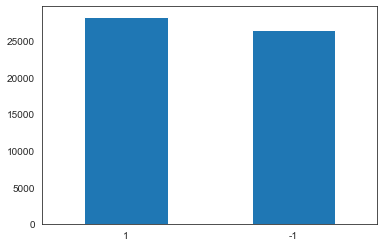

In [399]:
replacement_df.prediction.value_counts().plot(kind='bar', rot=0)

In [400]:
df_merged = pd.concat([df_tweets, replacement_df], axis=1)
df_merged.rename(columns={"prediction": "W2V-kNN"}, inplace=True)
df_merged.columns

Index(['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites',
       'retweets', 'date', 'isFlagged', 'retweeted', 'sentiment_text',
       'subjectivity_score', 'TextBlob_sa', 'Vader_sa', 'VADER', 'TextBlob',
       'sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment',
       'sentiment_rate', 'W2V-kNN'],
      dtype='object')

In [401]:
df_final = df_merged.iloc[:,[0,1,10,11,14,15,-1]]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54674 entries, 0 to 54673
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  54674 non-null  int64   
 1   text                54674 non-null  object  
 2   sentiment_text      54674 non-null  object  
 3   subjectivity_score  54674 non-null  float64 
 4   VADER               54674 non-null  category
 5   TextBlob            54422 non-null  category
 6   W2V-kNN             54674 non-null  int8    
dtypes: category(2), float64(1), int64(1), int8(1), object(2)
memory usage: 4.7+ MB


In [402]:
df_final.dropna(how='any', inplace=True)
df_final.VADER = df_final.VADER.astype(int)
df_final.TextBlob = df_final.TextBlob.cat.codes - 1
df_final['W2V-kNN'] = df_final['W2V-kNN'].astype(int)

<ipython-input-402-bdbf950dc954>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.dropna(how='any', inplace=True)
/Users/my_love/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-402-bdbf950dc954>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [403]:
df_final['Final'] = (df_final.VADER + df_final.TextBlob + df_final['W2V-kNN'])/3

<ipython-input-403-62f24c0e67c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Final'] = (df_final.VADER + df_final.TextBlob + df_final['W2V-kNN'])/3


In [404]:
cut_labels = [-1, 0, 1]
cut_bins = [-100, -0.00001, 0.00001, 100]
df_final['Final'] = pd.cut(df_final['Final'], bins=cut_bins, labels=cut_labels)

<ipython-input-404-03855659e3aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Final'] = pd.cut(df_final['Final'], bins=cut_bins, labels=cut_labels)


In [405]:
df_final['Final'].value_counts()

1     33397
-1    15045
0      5980
Name: Final, dtype: int64

<AxesSubplot:>

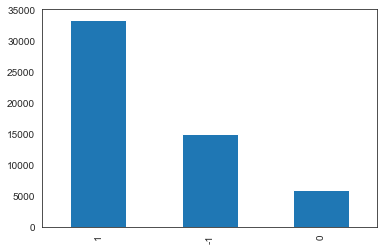

In [406]:
df_final['Final'].value_counts().plot(kind='bar')

In [407]:
df_final.to_csv('../output/sentiment_labels.csv')

In [408]:
df_final = pd.read_csv('../output/sentiment_labels.csv', index_col=None).iloc[:,1:]
df_final.head()

,id,text,sentiment_text,subjectivity_score,VADER,TextBlob,W2V-kNN,Final
0,98454970654916608,Republicans and Democrats have both created ou...,republicans democrats created economic problems,0.200000,-1,1,-1,-1
1,1234653427789070336,I was thrilled to be back in the Great city of...,thrilled_back great city charlotte north_carol...,0.483333,1,1,-1,1
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,read letter surveillance court obtained cbs ne...,0.100000,0,1,1,1
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,unsolicited mail_ballot scam major threat demo...,0.454762,-1,1,-1,-1
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,friendly telling events comey apparent leaking...,0.425000,1,1,-1,1


In [409]:
df_final['VADER'].value_counts()

 1    31041
-1    14684
 0     8697
Name: VADER, dtype: int64

In [410]:
df_final['TextBlob'].value_counts()

 1    28536
 0    15852
-1    10034
Name: TextBlob, dtype: int64

In [411]:
df_final['W2V-kNN'].value_counts()

 1    28148
-1    26274
Name: W2V-kNN, dtype: int64

In [412]:
df_final['Final'].value_counts()

 1    33397
-1    15045
 0     5980
Name: Final, dtype: int64